In [1]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import fit_wcs_from_points
from astropy.coordinates import SkyCoord
from astropy.table import Table
from itertools import combinations
from scipy.spatial import cKDTree
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import heapq
import itertools
import sep

# Parameters from REM_astrometry.py
N_SOURCES = 25
NUM_QUADS = 2000
HASH_TOL = 0.1
PIX_TOL = 1.0
TOP_MATCHES = 50

## 1. Load FITS and WCS

In [5]:
fname = '../../../../GRB/REM/process_REMIR/test_REMIR_align_K/p'

with fits.open(fname) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    wcs_original = WCS(header, relax=True)

print(f"Image shape: {data.shape}")

Image shape: (512, 512)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'degrees' -> 'deg',
  'degrees' -> 'deg'. [astropy.wcs.wcs]


## 2. Load Catalog

In [6]:
catalog_path = '../../../../GRB/REM/process_REMIR/test_old/proc/catalogs/catalog_1_ra198.6804_dec5.0330.csv'
cat_df = pd.read_csv(catalog_path)

# Convert to pixels using ORIGINAL WCS with origin=0
cat_ra = cat_df['RAJ2000'].values
cat_dec = cat_df['DEJ2000'].values
cat_mag = cat_df['H'].values

cat_pix_x, cat_pix_y = wcs_original.all_world2pix(cat_ra, cat_dec, 0)

cat_sources = []
for i in range(len(cat_ra)):
    if np.isfinite(cat_pix_x[i]) and np.isfinite(cat_pix_y[i]) and np.isfinite(cat_mag[i]):
        cat_sources.append({
            'x': float(cat_pix_x[i]),
            'y': float(cat_pix_y[i]),
            'ra': float(cat_ra[i]),
            'dec': float(cat_dec[i]),
            'mag': float(cat_mag[i])
        })

print(f"Catalog: {len(cat_sources)} sources")

Catalog: 116 sources


## 3. Detect Sources

In [7]:
# Ensure native byte order
if not data.dtype.isnative:
    data = data.astype(data.dtype.newbyteorder('='))
data = data.astype(np.float32)

# Background subtraction
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)
data_sub = data - bkg.back()
threshold = 2.0 * bkg.globalrms

# Extract sources
objects = sep.extract(data_sub, threshold, minarea=10)

det_sources = []
for obj in objects:
    det_sources.append({
        'x': float(obj['x']),
        'y': float(obj['y']),
        'flux': float(obj['flux']),
        'mag': -2.5 * np.log10(obj['flux']) + 25.0 if obj['flux'] > 0 else 99.0
    })

det_sources.sort(key=lambda x: x['mag'])

print(f"Detected: {len(det_sources)} sources")

Detected: 18 sources


## 4. Build Quads

In [8]:
def geometric_hash_code(quad):
    coords = np.array([[row['X'], row['Y']] for row in quad])
    dists = np.linalg.norm(coords[:, None] - coords[None, :], axis=2)
    i, j = np.unravel_index(np.argmax(dists), dists.shape)
    A, B = coords[i], coords[j]
    others = [coords[k] for k in range(4) if k not in (i, j)]
    C, D = others
    vec = B - A
    norm2 = np.sum(vec**2)
    perp = np.array([-vec[1], vec[0]])
    xC = np.dot(C - A, vec) / norm2
    yC = np.dot(C - A, perp) / norm2
    xD = np.dot(D - A, vec) / norm2
    yD = np.dot(D - A, perp) / norm2
    if xC > xD:
        xC, xD = xD, xC
        yC, yD = yD, yC
    if xC + xD > 1.0:
        xC, xD = 1 - xC, 1 - xD
        yC, yD = 1 - yC, 1 - yD
    return np.array([xC, yC, xD, yD])

def build_quads_heap(table, G=2000):
    table.sort('MAG')
    heap = []
    counter = itertools.count()
    for quad in combinations(table, 4):
        sum_mag = sum(row['MAG'] for row in quad)
        cnt = next(counter)
        if len(heap) < G:
            heapq.heappush(heap, (-sum_mag, cnt, quad))
        else:
            if sum_mag < -heap[0][0]:
                heapq.heapreplace(heap, (-sum_mag, cnt, quad))
    best_quads = [quad for _, _, quad in sorted(heap, key=lambda x: -x[0])]
    index = [
        {'quad': quad, 'hash': geometric_hash_code(quad),
         'coords': np.array([[row['X'], row['Y']] for row in quad])}
        for quad in best_quads
    ]
    return index

# Prepare tables
DET = np.array([[s['x'], s['y'], s['mag']] for s in det_sources])
CAT = np.array([[s['x'], s['y'], s['mag']] for s in cat_sources])

det_table = Table([DET[:, 0], DET[:, 1], DET[:, 2]], names=('X', 'Y', 'MAG'))
cat_table = Table([CAT[:, 0], CAT[:, 1], CAT[:, 2]], names=('X', 'Y', 'MAG'))

det_table.sort('MAG')
cat_table.sort('MAG')
det_table = det_table[:N_SOURCES]
cat_table = cat_table[:N_SOURCES]

print(f"Building quads from {len(det_table)} det and {len(cat_table)} cat sources...")
det_quads = build_quads_heap(det_table, G=NUM_QUADS)
cat_quads = build_quads_heap(cat_table, G=NUM_QUADS)
print(f"Built {len(det_quads)} det quads, {len(cat_quads)} cat quads")

Building quads from 18 det and 25 cat sources...
Built 2000 det quads, 2000 cat quads


## 5. Match Quads

In [9]:
matches = []
for det_q in det_quads:
    for cat_q in cat_quads:
        hash_diff = np.linalg.norm(det_q['hash'] - cat_q['hash'])
        if hash_diff < HASH_TOL:
            matches.append({
                'det_quad': det_q,
                'cat_quad': cat_q,
                'hash_diff': hash_diff
            })

matches_sorted = sorted(matches, key=lambda x: x['hash_diff'])
print(f"Found {len(matches)} quad matches")

Found 2473 quad matches


## 6. Collect Transformations and Find Consensus

In [10]:
def compute_similarity_transform(cat_coords, det_coords):
    cat_coords = np.asarray(cat_coords, dtype=np.float64)
    det_coords = np.asarray(det_coords, dtype=np.float64)
    cat_mean = np.mean(cat_coords, axis=0)
    det_mean = np.mean(det_coords, axis=0)
    X = cat_coords - cat_mean
    Y = det_coords - det_mean
    C = X.T @ Y
    U, S, Vt = np.linalg.svd(C)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[1, :] *= -1
        R = Vt.T @ U.T
    scale = np.trace(R @ C) / np.sum(X**2)
    t = det_mean - scale * (R @ cat_mean)
    return scale, R, t

# Collect all transformations (SILENTLY)
print(f"Computing transformations from {TOP_MATCHES} matches...")
all_transformations = []

cat_all_coords = np.array([[row['X'], row['Y']] for row in cat_table])
det_all_coords = np.array([[row['X'], row['Y']] for row in det_table])

for match in matches_sorted[:TOP_MATCHES]:
    try:
        scale, R, t = compute_similarity_transform(
            match['cat_quad']['coords'],
            match['det_quad']['coords']
        )
    except:
        continue
    
    # Count star matches
    cat_transformed = scale * (cat_all_coords @ R.T) + t
    tree = cKDTree(det_all_coords)
    distances, indices = tree.query(cat_transformed, k=1)
    n_matches = np.sum(distances < PIX_TOL)
    matched_pairs = [(i, indices[i]) for i in range(len(cat_all_coords)) if distances[i] < PIX_TOL]
    
    if matched_pairs:
        residuals = [np.linalg.norm(cat_transformed[i] - det_all_coords[j]) for i, j in matched_pairs]
        rms = np.sqrt(np.mean([r**2 for r in residuals]))
    else:
        rms = 999
    
    angle_deg = np.rad2deg(np.arctan2(R[1,0], R[0,0]))
    
    all_transformations.append({
        'scale': scale,
        'angle_deg': angle_deg,
        'tx': t[0],
        'ty': t[1],
        'R': R,
        't': t,
        'n_matches': n_matches,
        'rms': rms,
        'matched_pairs': matched_pairs
    })

print(f"Collected {len(all_transformations)} valid transformations")

Computing transformations from 50 matches...
Collected 50 valid transformations


In [11]:
# Group by similarity
# Scale: 2nd decimal (0.01 bins)
# Angle: 2nd decimal degrees (0.01° bins)
# Translation: unit pixel (1.0 bins)

groups = defaultdict(list)

for trans in all_transformations:
    scale_key = round(trans['scale'], 2)
    angle_key = round(trans['angle_deg'], 2)
    tx_key = round(trans['tx'], 0)
    ty_key = round(trans['ty'], 0)
    
    group_key = (scale_key, angle_key, tx_key, ty_key)
    groups[group_key].append(trans)

print(f"\nGrouped into {len(groups)} distinct groups")

# Find largest group (consensus)
largest_group_key = max(groups.keys(), key=lambda k: len(groups[k]))
largest_group = groups[largest_group_key]

print("\n" + "="*60)
print(f"LARGEST GROUP: {len(largest_group)} transformations")
print("="*60)
print(f"Scale bin: {largest_group_key[0]:.2f}")
print(f"Angle bin: {largest_group_key[1]:.2f}°")
print(f"Translation bin: ({largest_group_key[2]:.0f}, {largest_group_key[3]:.0f}) px")

# Compute median parameters
median_scale = np.median([t['scale'] for t in largest_group])
median_angle = np.median([t['angle_deg'] for t in largest_group])
median_tx = np.median([t['tx'] for t in largest_group])
median_ty = np.median([t['ty'] for t in largest_group])
median_n_matches = np.median([t['n_matches'] for t in largest_group])
median_rms = np.median([t['rms'] for t in largest_group])

print("\nMEDIAN PARAMETERS:")
print(f"  Scale: {median_scale:.4f}")
print(f"  Angle: {median_angle:.2f}°")
print(f"  Translation: ({median_tx:.2f}, {median_ty:.2f}) px")
print(f"  Star matches: {median_n_matches:.0f}")
print(f"  RMS: {median_rms:.3f} px")

# Reconstruct transformation from median
median_angle_rad = np.deg2rad(median_angle)
R_final = np.array([
    [np.cos(median_angle_rad), -np.sin(median_angle_rad)],
    [np.sin(median_angle_rad), np.cos(median_angle_rad)]
])
t_final = np.array([median_tx, median_ty])

# Use best matched_pairs from group
best_in_group = max(largest_group, key=lambda t: t['n_matches'] - t['rms'])

best_match = {
    'scale': median_scale,
    'R': R_final,
    't': t_final,
    'n_star_matches': int(median_n_matches),
    'rms': median_rms,
    'matched_pairs': best_in_group['matched_pairs'],
    'group_size': len(largest_group)
}

print("\n" + "="*60)
print("TOP 5 GROUPS:")
print("="*60)
sorted_groups = sorted(groups.items(), key=lambda x: len(x[1]), reverse=True)
for i, (key, group) in enumerate(sorted_groups[:5]):
    med_matches = np.median([t['n_matches'] for t in group])
    med_rms = np.median([t['rms'] for t in group])
    print(f"{i+1}. n={len(group):3d} | scale={key[0]:.2f}, angle={key[1]:6.2f}°, t=({key[2]:5.0f},{key[3]:5.0f}) | matches={med_matches:.0f}, rms={med_rms:.3f}px")

print("\n✓ Using consensus transformation from largest group")


Grouped into 50 distinct groups

LARGEST GROUP: 1 transformations
Scale bin: 0.99
Angle bin: -3.31°
Translation bin: (12, 26) px

MEDIAN PARAMETERS:
  Scale: 0.9882
  Angle: -3.31°
  Translation: (11.75, 25.93) px
  Star matches: 6
  RMS: 0.510 px

TOP 5 GROUPS:
1. n=  1 | scale=0.99, angle= -3.31°, t=(   12,   26) | matches=6, rms=0.510px
2. n=  1 | scale=0.99, angle= -3.07°, t=(   13,   25) | matches=7, rms=0.712px
3. n=  1 | scale=0.07, angle=-116.54°, t=(  222,  146) | matches=0, rms=999.000px
4. n=  1 | scale=1.00, angle= 41.13°, t=(  477, -349) | matches=0, rms=999.000px
5. n=  1 | scale=0.63, angle=-166.15°, t=(  211,  576) | matches=0, rms=999.000px

✓ Using consensus transformation from largest group


## 7. Visualize

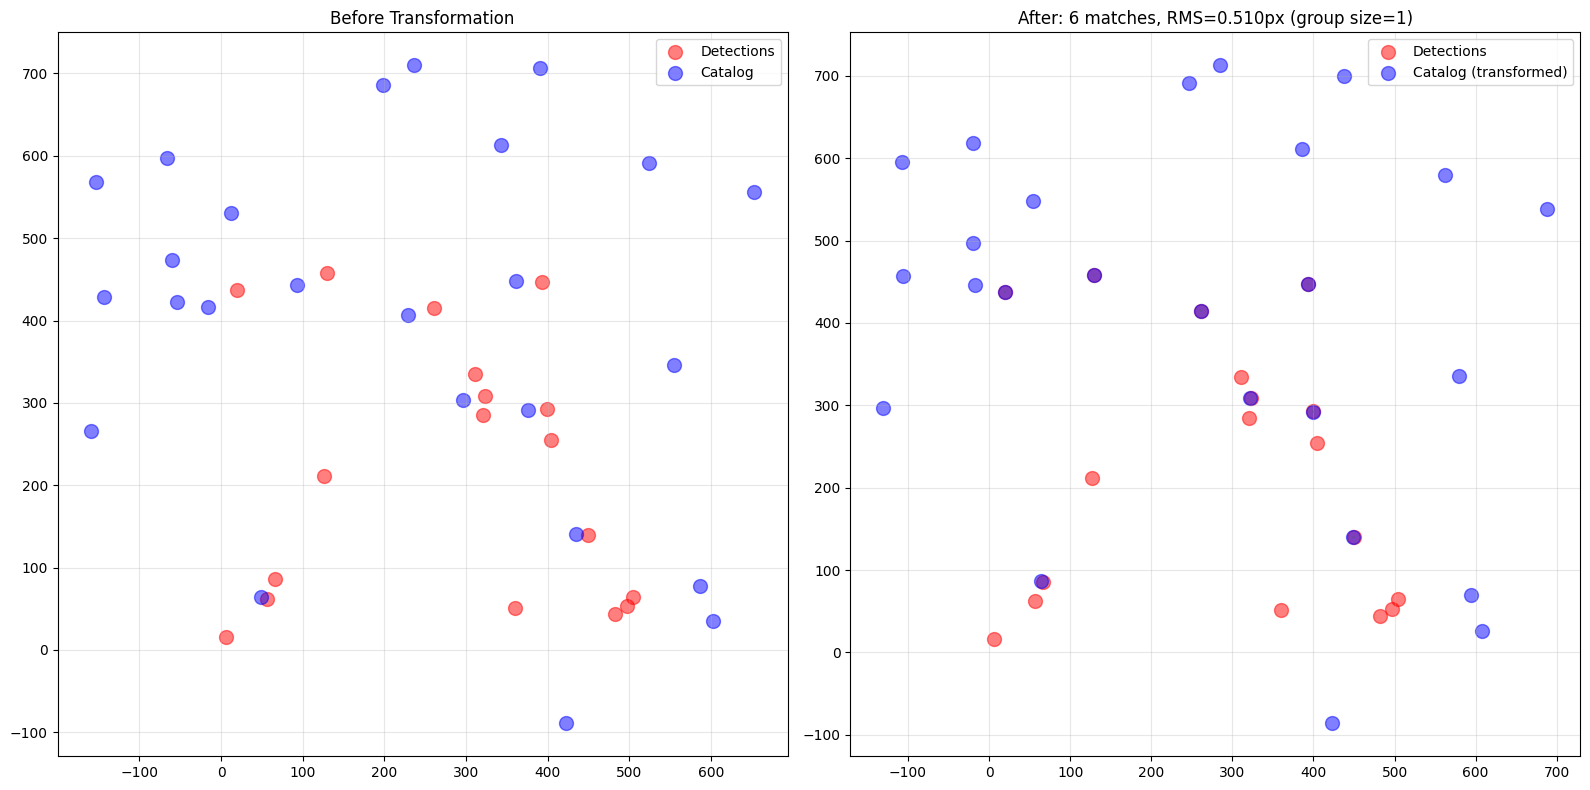

In [12]:
cat_coords = np.array([[row['X'], row['Y']] for row in cat_table])
det_coords = np.array([[row['X'], row['Y']] for row in det_table])

scale = best_match['scale']
R = best_match['R']
t = best_match['t']

cat_transformed = scale * (cat_coords @ R.T) + t

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Before
ax1.scatter(det_coords[:, 0], det_coords[:, 1], c='red', s=100, alpha=0.5, label='Detections')
ax1.scatter(cat_coords[:, 0], cat_coords[:, 1], c='blue', s=100, alpha=0.5, label='Catalog')
ax1.set_title('Before Transformation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# After
ax2.scatter(det_coords[:, 0], det_coords[:, 1], c='red', s=100, alpha=0.5, label='Detections')
ax2.scatter(cat_transformed[:, 0], cat_transformed[:, 1], c='blue', s=100, alpha=0.5, label='Catalog (transformed)')

for i, j in best_match['matched_pairs']:
    ax2.plot([cat_transformed[i, 0], det_coords[j, 0]], 
            [cat_transformed[i, 1], det_coords[j, 1]], 
            'g-', alpha=0.3, linewidth=1)

ax2.set_title(f'After: {best_match["n_star_matches"]} matches, RMS={best_match["rms"]:.3f}px (group size={best_match["group_size"]})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Fit WCS

In [10]:
if best_match['n_star_matches'] >= 4:
    # Apply to full catalog
    CAT_all = np.array([[s['x'], s['y']] for s in cat_sources])
    CAT_all_transformed = scale * (CAT_all @ R.T) + t
    
    cat_sky = SkyCoord(
        ra=[s['ra'] for s in cat_sources],
        dec=[s['dec'] for s in cat_sources],
        unit='deg'
    )
    
    print(f"Fitting WCS with {len(CAT_all_transformed)} sources...")
    wcs_new = fit_wcs_from_points(
        xy=CAT_all_transformed.T,
        world_coords=cat_sky,
        projection='TAN',
        sip_degree=3
    )
    
    print("✓ WCS fitted successfully!")
    print(wcs_new)
else:
    print("Not enough matches")

Fitting WCS with 45 sources...
✓ WCS fitted successfully!
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 198.68284271713344  5.033391240210543  
CRPIX : 253.34102605934635  354.0397233353663  
CD1_1 CD1_2  : -0.000337957221594822  6.045916678361034e-05  
CD2_1 CD2_2  : 6.045916925905468e-05  0.0003379572222735938  
NAXIS : 576  635
